In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [30]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout


In [14]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()



,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [15]:
# Check for null values
df.isnull().sum()

# Drop null values
df = df.dropna()




<Axes: xlabel='sentiment', ylabel='count'>

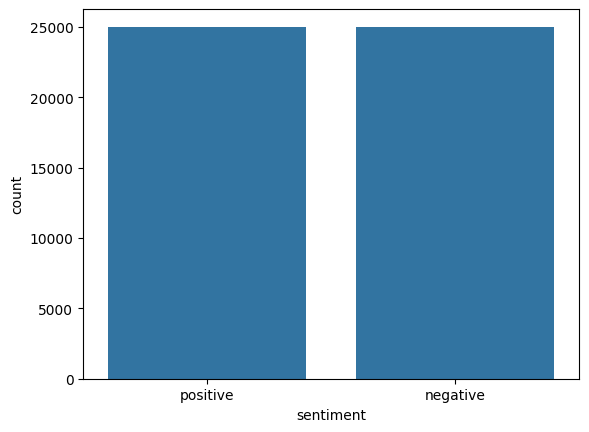

In [16]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=df)

In [17]:
df["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [19]:


from nltk.stem import WordNetLemmatizer

# Download required NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define preprocessing function
def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()
    
    # 2. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # 3. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 4. Remove special characters and numbers
    text = re.sub(r'\W|\d', ' ', text)
    
    # 5. Tokenization
    tokens = text.split()
    
    # 6. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # 7. Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text


# Apply preprocessing to the 'text' column
df['review'] = df['review'].apply(preprocess_text)

print(df['review'])



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sayus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sayus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0        one reviewer mentioned watching oz episode hoo...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake think zombie ...
4        petter mattei love time money visually stunnin...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary school nu...
49998    going disagree previous comment side maltin on...
49999    one expects star trek movie high art fan expec...
Name: review, Length: 50000, dtype: object


In [20]:
df['review'][2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty character likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many u grown love laughed one woody comedy year dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wear prada interesting superman great comedy go see friend'

In [21]:
# Converting the sentiment column to numerical values
df['sentiment']=df['sentiment'].map({'positive':1,'negative':0})

df.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


In [23]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)




In [24]:
# Preparing the tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)



In [37]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(tokenizer.word_index) + 1

vocab_length

83839

In [38]:
# Padding the sequences
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)




In [39]:
# Glove Embeddings 
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()



In [40]:
# Creating embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



In [41]:
embedding_matrix.shape


(83839, 100)

In [42]:
# model building
# Creating the model
model = Sequential()

# Adding the embedding layer using pre-trained GloVe embeddings
model.add(Embedding(len(tokenizer.word_index) + 1, 100, 
                   weights=[embedding_matrix], 
                   input_length=100, 
                   trainable=False))

# Adding a Flatten layer to convert 3D tensor to 2D
model.add(Flatten())

# Adding Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     8,383,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,383,900 (31.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,383,900 (31.98 MB)

In [43]:
# Model training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))





Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6140 - loss: 0.6602 - val_accuracy: 0.7476 - val_loss: 0.5357
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7411 - loss: 0.5156 - val_accuracy: 0.7519 - val_loss: 0.5102
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.7703 - loss: 0.4732 - val_accuracy: 0.7563 - val_loss: 0.5036
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7921 - loss: 0.4362 - val_accuracy: 0.7642 - val_loss: 0.4903
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8042 - loss: 0.4149 - val_accuracy: 0.7578 - val_loss: 0.4935
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8139 - loss: 0.3920 - val_accuracy: 0.7618 - val_loss: 0.4948
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8205 - loss: 0.3757 - val_accuracy: 0.7652 - val_loss: 0.4920
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8363 - loss: 0.3486 - 

In [44]:
# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7644 - loss: 0.5200
Test Loss: 0.5235418677330017
Test Accuracy: 0.7585999965667725


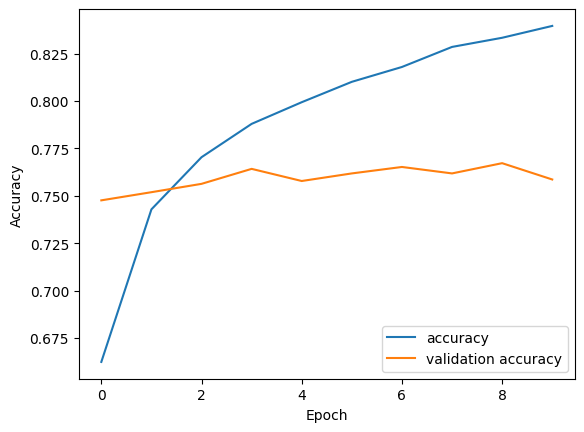

In [45]:
# Model performance curve
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


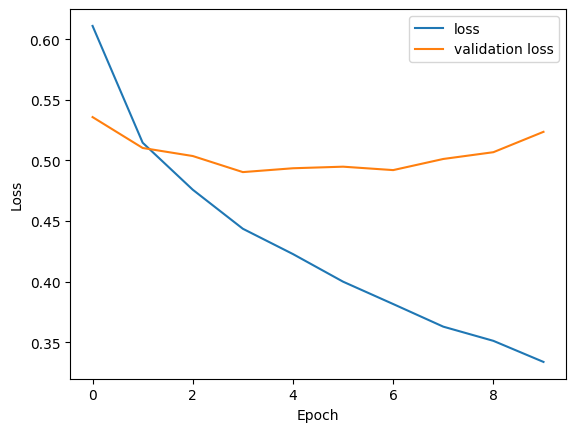

In [46]:
# for loss curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


## CNN


In [51]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=100 , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [52]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     8,383,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,383,900 (31.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,383,900 (31.98 MB)

None


In [53]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - acc: 0.7207 - loss: 0.5404 - val_acc: 0.8391 - val_loss: 0.3711
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - acc: 0.8548 - loss: 0.3441 - val_acc: 0.8526 - val_loss: 0.3427
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - acc: 0.8892 - loss: 0.2818 - val_acc: 0.8524 - val_loss: 0.3416
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - acc: 0.9160 - loss: 0.2333 - val_acc: 0.8543 - val_loss: 0.3323
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - acc: 0.9306 - loss: 0.2021 - val_acc: 0.8627 - val_loss: 0.3225
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - acc: 0.9524 - loss: 0.1635 - val_acc: 0.8568 - val_loss: 0.3310


In [54]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (score[1]*100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.8591 - loss: 0.3401
Accuracy: 85.45%


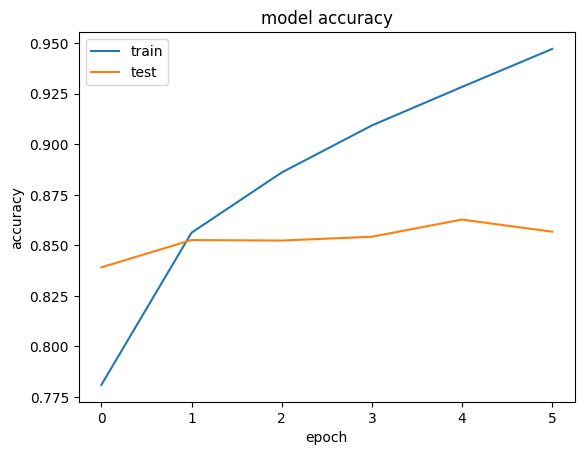

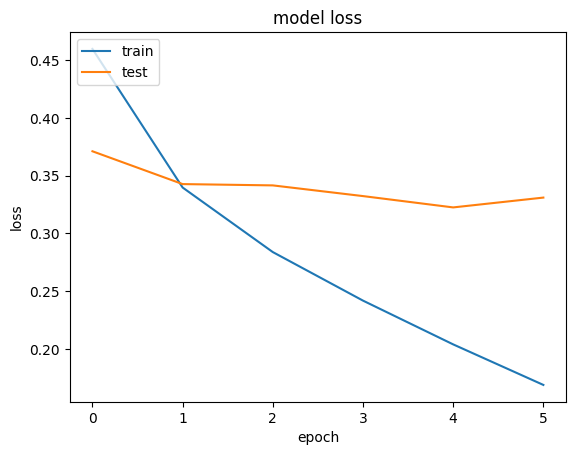

In [55]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## RNN


In [56]:
from keras.layers import LSTM

In [57]:
# Model building

rnn_model = Sequential()

rnn_model.add(embedding_layer)
rnn_model.add(LSTM(128))
rnn_model.add(Dense(1, activation='sigmoid'))


In [58]:
# Model compiling

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(rnn_model.summary())
# Model training

rnn_model_history = rnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (128, 100, 100)        │     8,383,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,383,900 (31.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,383,900 (31.98 MB)

None
Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 116ms/step - acc: 0.7107 - loss: 0.5470 - val_acc: 0.7651 - val_loss: 0.4645
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - acc: 0.8118 - loss: 0.4104 - val_acc: 0.8414 - val_loss: 0.3580
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - acc: 0.8437 - loss: 0.3607 - val_acc: 0.8528 - val_loss: 0.3565
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - acc: 0.8558 - loss: 0.3331 - val_acc: 0.8614 - val_loss: 0.3225
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - acc: 0.8637 - loss: 0.3164 - val_acc: 0.8651 - val_loss: 0.3184
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - acc: 0.8759 - loss: 0.2952 - val_acc: 0.8700 - val_loss: 0.3107


In [59]:
# Model evaluation

score = rnn_model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (score[1]*100))



313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.8686 - loss: 0.3188
Accuracy: 86.58%


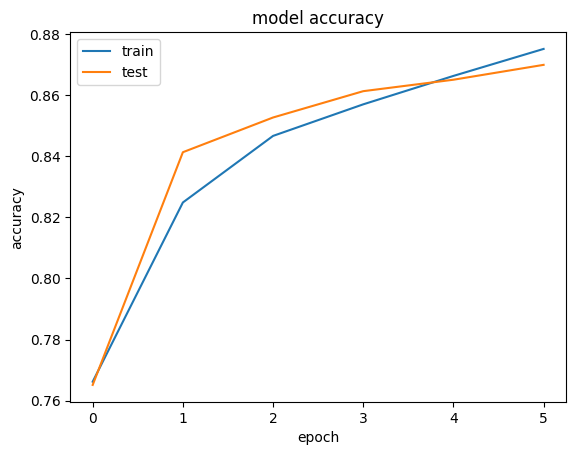

In [62]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(rnn_model_history.history['acc'])
plt.plot(rnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


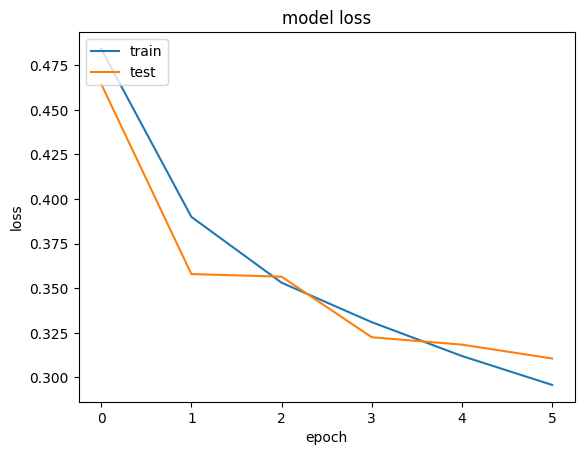

In [63]:
# For loss curve
plt.plot(rnn_model_history.history['loss'])
plt.plot(rnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


In [65]:
# Create a pipeline class for model training and evaluation
class ModelPipeline:
    def __init__(self, model):
        self.model = model
        self.history = None
        
    def train(self, X_train, y_train, batch_size=128, epochs=6, validation_split=0.2):
        """Train the model and store history"""
        self.history = self.model.fit(
            X_train, 
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=validation_split
        )
        return self
        
    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        score = self.model.evaluate(X_test, y_test, verbose=1)
        print("Accuracy: %.2f%%" % (score[1]*100))
        return score
        
    def plot_metrics(self):
        """Plot accuracy and loss curves"""
        # Accuracy plot
        plt.figure(figsize=(10,4))
        
        plt.subplot(1,2,1)
        plt.plot(self.history.history['acc'])
        plt.plot(self.history.history['val_acc'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        
        # Loss plot
        plt.subplot(1,2,2)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        
        plt.tight_layout()
        plt.show()




In [67]:
# Example text for prediction
texts = [
    "This movie was absolutely fantastic! The acting and direction were superb.",
    "I didn't enjoy this film at all. The plot was confusing and the acting was poor.",
    "An average movie, had some good moments but overall nothing special."
]

# Preprocess the texts using the same pipeline
preprocessed_texts = []
for text in texts:
    # Clean and tokenize
    text = text.lower()
    text = re.sub('<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub('[^a-zA-Z\s]', '', text)  # Keep only letters
    
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    preprocessed_texts.append(' '.join(words))

# Convert to sequences
sequences = tokenizer.texts_to_sequences(preprocessed_texts)

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=100)

# Make predictions
predictions = rnn_model.predict(padded_sequences)

# Print results
for text, pred in zip(texts, predictions):
    sentiment = "Positive" if pred > 0.5 else "Negative"
    confidence = pred if pred > 0.5 else 1 - pred
    print(f"\nText: {text}")
    print(f"Sentiment: {sentiment} (confidence: {confidence[0]:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step

Text: This movie was absolutely fantastic! The acting and direction were superb.
Sentiment: Positive (confidence: 0.98)

Text: I didn't enjoy this film at all. The plot was confusing and the acting was poor.
Sentiment: Negative (confidence: 0.94)

Text: An average movie, had some good moments but overall nothing special.
Sentiment: Positive (confidence: 0.72)
